In [3]:
import pandas as pd
import yfinance as yf


In [2]:
%pip install yfinance --quiet

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:

ticker = "AAPL"
df = yf.download(ticker, start="2018-01-01", end="2025-01-01")
df = df.dropna().copy()
df.head()


C:\Users\mayank goyal\AppData\Local\Temp\ipykernel_21072\309189328.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.341896,40.351266,39.639320,39.850095,102223600
2018-01-03,40.334862,40.878189,40.271633,40.405120,118071600
2018-01-04,40.522209,40.625254,40.299728,40.407454,89738400
2018-01-05,40.983574,41.070224,40.526901,40.618235,94640000
2018-01-08,40.831356,41.126437,40.732992,40.831356,82271200


In [7]:
import numpy as np

df["ret_1"] = df["Close"].pct_change()
df["lag_close_1"] = df["Close"].shift(1)
df["lag_ret_1"]   = df["ret_1"].shift(1)

df["ma_5"]  = df["Close"].rolling(5).mean()
df["ma_20"] = df["Close"].rolling(20).mean()
df["vol_20"] = df["ret_1"].rolling(20).std()

# Predict next day's close (you can switch to next-day return later)
df["y"] = df["Close"].shift(-1)

data = df.dropna().copy()

features = ["lag_close_1", "lag_ret_1", "ma_5", "ma_20", "vol_20", "Volume"]
X = data[features]
y = data["y"]


In [5]:
df.shape

(1761, 5)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2018-01-02 to 2024-12-31
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, AAPL)    1761 non-null   float64
 1   (High, AAPL)     1761 non-null   float64
 2   (Low, AAPL)      1761 non-null   float64
 3   (Open, AAPL)     1761 non-null   float64
 4   (Volume, AAPL)   1761 non-null   int64  
 5   (ret_1, )        1760 non-null   float64
 6   (lag_close_1, )  1760 non-null   float64
 7   (lag_ret_1, )    1759 non-null   float64
 8   (ma_5, )         1757 non-null   float64
 9   (ma_20, )        1742 non-null   float64
 10  (vol_20, )       1741 non-null   float64
 11  (y, )            1760 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 178.9 KB


In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [12]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


model = DecisionTreeRegressor(
    max_depth=6,
    min_samples_leaf=25,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)   # <-- this was missing

pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

(mae, rmse)

(17.789215029291135, np.float64(25.94702917913902))

In [13]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [14]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [15]:
tscv = TimeSeriesSplit(n_splits=5)

In [16]:
dt = DecisionTreeRegressor(random_state=42)

In [17]:
param_grid = {
    "max_depth": [3, 5, 8, 12, None],
    "min_samples_leaf": [1, 10, 25, 50],
    "min_samples_split": [2, 10, 50, 100],
}

In [19]:
grid = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",  # optimize MAE (bigger is better because it's negative)
    n_jobs=-1,
)

In [20]:
grid.fit(X_train, y_train)


,estimator,DecisionTreeR...ndom_state=42)
,param_grid,"{'max_depth': [3, 5, ...], 'min_samples_leaf': [1, 10, ...], 'min_samples_split': [2, 10, ...]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'squared_error'


In [21]:
best_model = grid.best_estimator_
print("Best params:", grid.best_params_)
print("CV score (neg MAE):", grid.best_score_)

Best params: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 10}
CV score (neg MAE): -9.983225346204636


In [22]:
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [26]:
rmse,mae

(np.float64(29.66053096646805), 20.91436717871701)

In [25]:
rmse

np.float64(29.66053096646805)

In [27]:
y_pred_naive = X_test["lag_close_1"].values

mae_naive = mean_absolute_error(y_test, y_pred_naive)
rmse_naive = np.sqrt(mean_squared_error(y_test, y_pred_naive))

print("NAIVE MAE:", mae_naive)
print("NAIVE RMSE:", rmse_naive)

NAIVE MAE: 2.9667516247979524
NAIVE RMSE: 3.9584451544743913


In [28]:

fi = pd.Series(best_model.feature_importances_, index=X_train.columns)\
       .sort_values(ascending=False)

In [29]:
fi 

Price        Ticker
ma_20                  0.862689
ma_5                   0.069444
lag_close_1            0.067055
vol_20                 0.000484
Volume       AAPL      0.000208
lag_ret_1              0.000120
dtype: float64

In [30]:
import matplotlib.pyplot as plt


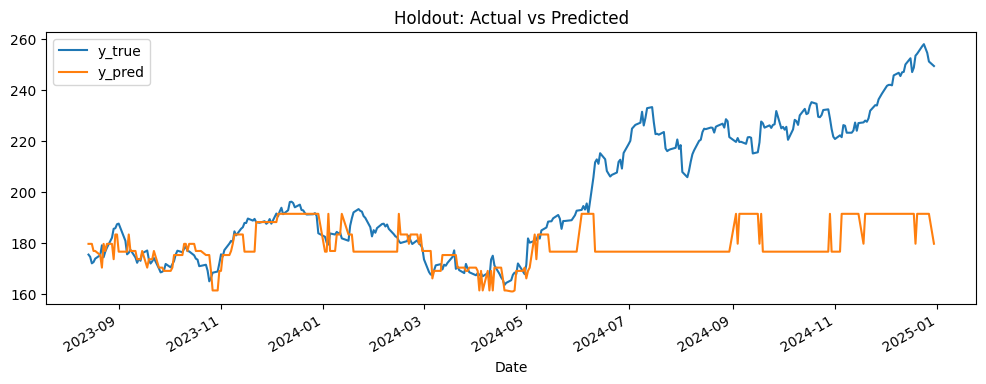

In [31]:

pred_df = pd.DataFrame({"y_true": y_test.values, "y_pred": y_pred}, index=y_test.index)
pred_df[["y_true","y_pred"]].plot(figsize=(12,4), title="Holdout: Actual vs Predicted")
plt.show()

In [32]:
y_pred_naive = X_test["lag_close_1"].values  # Close(t)
mae_naive = mean_absolute_error(y_test, y_pred_naive)
rmse_naive = np.sqrt(mean_squared_error(y_test, y_pred_naive))

print("Naive MAE:", mae_naive)
print("Naive RMSE:", rmse_naive)

Naive MAE: 2.9667516247979524
Naive RMSE: 3.9584451544743913


In [33]:
# Build returns
df["ret_1"] = df["Close"].pct_change()

# Target: next-day return
df["y"] = df["ret_1"].shift(-1)

# Features (example set; keep expanding later)
df["lag_ret_1"] = df["ret_1"].shift(1)
df["ret_5"] = df["Close"].pct_change(5)
df["ma_5"]  = df["Close"].rolling(5).mean()
df["ma_20"] = df["Close"].rolling(20).mean()
df["vol_20"] = df["ret_1"].rolling(20).std()

data = df.dropna().copy()
X = data[["lag_ret_1","ret_5","ma_5","ma_20","vol_20","Volume"]]
y = data["y"]


In [34]:
y_pred_naive = np.zeros_like(y_test)  # predict 0 return


In [35]:
# Suppose you predicted returns for the test window: r_hat (same index as X_test)
r_hat = best_model.predict(X_test)

# Start from today's close (aligned)
p0 = df.loc[X_test.index, "Close"]  # today's close at each test date

# One-step-ahead predicted close: P_{t+1} = P_t * (1 + r_{t+1})
p1_hat = p0.values * (1.0 + r_hat)


In [ ]:
y_pred = best_model.predict(X_test)

# 2) Metrics
mae = mean_absolute_error(y_test, y_pred)         
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 20.91436717871701
RMSE: 29.66053096646805


In [37]:
y_pred_naive = X_test["lag_close_1"].values

mae_naive = mean_absolute_error(y_test, y_pred_naive)
rmse_naive = np.sqrt(mean_squared_error(y_test, y_pred_naive))

print("Naive MAE:", mae_naive)
print("Naive RMSE:", rmse_naive)
print("MAE improvement:", mae_naive - mae)   # positive means model is better
print("RMSE improvement:", rmse_naive - rmse)

Naive MAE: 2.9667516247979524
Naive RMSE: 3.9584451544743913
MAE improvement: -17.947615553919057
RMSE improvement: -25.70208581199366


In [ ]:


df = df.copy()

# 1) Daily returns
df["ret_1"] = df["Close"].pct_change()  

# 2) Features (lags + rolling indicators)
df["lag_ret_1"] = df["ret_1"].shift(1)
df["ret_5"] = df["Close"].pct_change(5)             
df["vol_20"] = df["ret_1"].rolling(20).std()           
df["ma_5"]  = df["Close"].rolling(5).mean()           
df["ma_20"] = df["Close"].rolling(20).mean()          

# 3) Target: next-day return
df["y"] = df["ret_1"].shift(-1)

data = df.dropna().copy()

X = data[["lag_ret_1", "ret_5", "vol_20", "ma_5", "ma_20", "Volume"]]
y = data["y"]

print("Raw df shape:", df.shape)
print("Columns:", df.columns)

tmp = df.copy()
tmp["ret_1"] = tmp["Close"].pct_change()           
tmp["vol_20"] = tmp["ret_1"].rolling(20).std()      
tmp["y"] = tmp["ret_1"].shift(-1)

print("After features (before dropna) shape:", tmp.shape)
print("Rows after dropna:", tmp.dropna().shape)
print("First date:", tmp.index.min(), "Last date:", tmp.index.max())



Raw df shape: (1761, 13)
Columns: MultiIndex([(      'Close', 'AAPL'),
            (       'High', 'AAPL'),
            (        'Low', 'AAPL'),
            (       'Open', 'AAPL'),
            (     'Volume', 'AAPL'),
            (      'ret_1',     ''),
            ('lag_close_1',     ''),
            (  'lag_ret_1',     ''),
            (       'ma_5',     ''),
            (      'ma_20',     ''),
            (     'vol_20',     ''),
            (          'y',     ''),
            (      'ret_5',     '')],
           names=['Price', 'Ticker'])
After features (before dropna) shape: (1761, 13)
Rows after dropna: (0, 13)
First date: 2018-01-02 00:00:00 Last date: 2024-12-31 00:00:00


In [45]:

df = df.copy()

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)  

print(df.columns)


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'ret_1', 'lag_close_1',
       'lag_ret_1', 'ma_5', 'ma_20', 'vol_20', 'y', 'ret_5'],
      dtype='object', name='Price')


In [44]:
df["ret_1"] = df["Close"].pct_change()
df["lag_ret_1"] = df["ret_1"].shift(1)
df["ret_5"] = df["Close"].pct_change(5)
df["vol_20"] = df["ret_1"].rolling(20).std()
df["ma_5"]  = df["Close"].rolling(5).mean()
df["ma_20"] = df["Close"].rolling(20).mean()

df["y"] = df["ret_1"].shift(-1)  # next-day return target

data = df.dropna().copy()
X = data[["lag_ret_1", "ret_5", "vol_20", "ma_5", "ma_20", "Volume"]]
y = data["y"]

print("Rows after dropna:", data.shape[0])

Rows after dropna: 1740


In [46]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

model = DecisionTreeRegressor(max_depth=6, min_samples_leaf=25, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Baseline for returns: predict 0 return
y_pred_naive = np.zeros_like(y_test.values)

def metrics(y_true, y_hat):
    mae = mean_absolute_error(y_true, y_hat)                 # [web:119]
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))        # [web:21]
    return mae, rmse

mae, rmse = metrics(y_test, y_pred)
mae_n, rmse_n = metrics(y_test, y_pred_naive)

print("MODEL  MAE:", mae, "RMSE:", rmse)
print("NAIVE  MAE:", mae_n, "RMSE:", rmse_n)
print("MAE improvement:", mae_n - mae)     # +ve => model wins
print("RMSE improvement:", rmse_n - rmse)  # +ve => model wins

MODEL  MAE: 0.011491510319653103 RMSE: 0.01501442411412448
NAIVE  MAE: 0.010131795554893104 RMSE: 0.013651128271436365
MAE improvement: -0.001359714764759998
RMSE improvement: -0.0013632958426881142


In [48]:
mae_model = mean_absolute_error(y_test, y_pred)            
mae_naive = mean_absolute_error(y_test, y_pred_naive)      
mase = mae_model / mae_naive                                

print("MAE model:", mae_model)
print("MAE naive:", mae_naive)
print("MASE:", mase, "(<1 is better than naive)")

MAE model: 0.011491510319653103
MAE naive: 0.010131795554893104
MASE: 1.1342027439650941 (<1 is better than naive)


In [49]:
y_dir = (y > 0).astype(int)

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y_dir.iloc[:split_idx], y_dir.iloc[split_idx:]

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=50, random_state=42)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))


Accuracy: 0.47413793103448276


In [50]:
pos_rate = y_test.mean()                 # % of 1s in test
majority_acc = max(pos_rate, 1 - pos_rate)

print("Positive rate (up days):", pos_rate)
print("Majority baseline accuracy:", majority_acc)

Positive rate (up days): 0.5660919540229885
Majority baseline accuracy: 0.5660919540229885


In [51]:
from sklearn.metrics import confusion_matrix  # [web:217]

cm = confusion_matrix(y_test, pred)  # pred = clf.predict(X_test) [web:217]
print(cm)


[[ 80  71]
 [112  85]]


In [52]:
from sklearn.metrics import balanced_accuracy_score

In [53]:
bal_acc = balanced_accuracy_score(y_test, pred) 
print("Balanced accuracy:", bal_acc)

Balanced accuracy: 0.48063670286079274


In [54]:
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

# 1) Basic + baseline
pos_rate = y_test.mean()
majority_baseline_acc = max(pos_rate, 1 - pos_rate)

acc = accuracy_score(y_test, pred)
bal_acc = balanced_accuracy_score(y_test, pred)

print("Positive rate (up days):", pos_rate)
print("Majority baseline accuracy:", majority_baseline_acc)
print("Accuracy:", acc)
print("Balanced accuracy:", bal_acc)

# 2) Confusion matrix
cm = confusion_matrix(y_test, pred)
print("\nConfusion matrix [[TN FP],[FN TP]]:\n", cm)

# 3) Precision/Recall/F1 breakdown
print("\nClassification report:\n")
print(classification_report(y_test, pred, digits=4))

# 4) ROC-AUC (only if classifier supports probabilities)
if hasattr(clf, "predict_proba"):
    proba_pos = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, proba_pos)
    print("ROC-AUC:", auc)
else:
    print("ROC-AUC: skipped (no predict_proba).")

Positive rate (up days): 0.5660919540229885
Majority baseline accuracy: 0.5660919540229885
Accuracy: 0.47413793103448276
Balanced accuracy: 0.48063670286079274

Confusion matrix [[TN FP],[FN TP]]:
 [[ 80  71]
 [112  85]]

Classification report:

              precision    recall  f1-score   support

           0     0.4167    0.5298    0.4665       151
           1     0.5449    0.4315    0.4816       197

    accuracy                         0.4741       348
   macro avg     0.4808    0.4806    0.4740       348
weighted avg     0.4892    0.4741    0.4750       348

ROC-AUC: 0.48951154738292935


In [55]:
df = yf.download(ticker, start="2018-01-01", end="2025-01-01", auto_adjust=False)


[*********************100%***********************]  1 of 1 completed


In [56]:
df = df.copy()
df["ret_1"] = df["Close"].pct_change()
df["ret_fwd_5"] = df["Close"].pct_change(5).shift(-5)     # future 5-day return [web:128]
df["y_dir_5"] = (df["ret_fwd_5"] > 0).astype(int)

# 2) Features (basic)
df["lag_ret_1"] = df["ret_1"].shift(1)
df["vol_20"] = df["ret_1"].rolling(20).std()
df["mom_5"] = df["Close"].pct_change(5)
df["mom_20"] = df["Close"].pct_change(20)

data = df.dropna().copy()
X = data[["lag_ret_1","vol_20","mom_5","mom_20","Volume"]]
y = data["y_dir_5"]

# 3) Split
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
proba = rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, pred))
print("ROC-AUC:", roc_auc_score(y_test, proba))

Accuracy: 0.5689655172413793
Balanced accuracy: 0.5133626920361717
ROC-AUC: 0.5189430866978183


In [57]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_reg = data["ret_fwd_5"]  # continuous target

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 0.026245672699219832
RMSE: 0.033031992133506036


In [58]:
y_pred = gbr.predict(X_test)

# Baseline: predict 0 return
y_pred_naive = np.zeros_like(y_test.values)

# Metrics
mae_model = mean_absolute_error(y_test, y_pred)  # [web:119]
rmse_model = np.sqrt(mean_squared_error(y_test, y_pred))  # [web:21]

mae_naive = mean_absolute_error(y_test, y_pred_naive)  # [web:119]
rmse_naive = np.sqrt(mean_squared_error(y_test, y_pred_naive))  # [web:21]

mase = mae_model / mae_naive  # <1 better than naive [web:199]

print("MODEL  MAE:", mae_model, "RMSE:", rmse_model)
print("NAIVE  MAE:", mae_naive, "RMSE:", rmse_naive)
print("MASE:", mase, "(<1 is better)")
print("MAE improvement:", mae_naive - mae_model)
print("RMSE improvement:", rmse_naive - rmse_model)

MODEL  MAE: 0.026245672699219832 RMSE: 0.033031992133506036
NAIVE  MAE: 0.025457956535420555 RMSE: 0.03204484955201517
MASE: 1.030941845733113 (<1 is better)
MAE improvement: -0.000787716163799277
RMSE improvement: -0.0009871425814908658


In [59]:
from sklearn.metrics import accuracy_score 

y_true_dir = (y_test.values > 0).astype(int)
y_pred_dir = (y_pred > 0).astype(int)

print("Directional accuracy:", accuracy_score(y_true_dir, y_pred_dir)) 


Directional accuracy: 0.5172413793103449


In [60]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [61]:
tscv = TimeSeriesSplit(n_splits=5)  

rf = RandomForestClassifier(
    n_estimators=800,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)

In [64]:
import numpy as np
import pandas as pd

# df must already have single-level columns: Close, Volume, etc.

df = df.copy()

# 1) Returns + 5-day forward return
df["ret_1"] = df["Close"].pct_change()                          # [web:129]
df["ret_fwd_5"] = df["Close"].pct_change(5).shift(-5)           # future 5-day return [web:129]

# 2) Direction label (this is y_dir_5 ✅)
df["y_dir_5"] = (df["ret_fwd_5"] > 0).astype(int)

# 3) Features
df["lag_ret_1"] = df["ret_1"].shift(1)
df["vol_20"] = df["ret_1"].rolling(20).std()
df["mom_5"] = df["Close"].pct_change(5)
df["mom_20"] = df["Close"].pct_change(20)

data = df.dropna().copy()

X = data[["lag_ret_1", "vol_20", "mom_5", "mom_20", "Volume"]]
y_dir_5 = data["y_dir_5"]

print("X shape:", X.shape)
print("y_dir_5 value counts:\n", y_dir_5.value_counts())


X shape: (0, 5)
y_dir_5 value counts:
 Series([], Name: count, dtype: int64)


In [66]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score  # [web:316]
from sklearn.ensemble import RandomForestClassifier

tscv = TimeSeriesSplit(n_splits=5)

rf = RandomForestClassifier(
    n_estimators=800,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
# 0) Ensure flat columns every time after download
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# 1) Build label + features
df = df.copy()
df["ret_1"] = df["Close"].pct_change()
df["ret_fwd_5"] = df["Close"].pct_change(5).shift(-5)
df["y_dir_5"] = (df["ret_fwd_5"] > 0).astype(int)

df["lag_ret_1"] = df["ret_1"].shift(1)
df["vol_20"] = df["ret_1"].rolling(20).std()
df["mom_5"] = df["Close"].pct_change(5)
df["mom_20"] = df["Close"].pct_change(20)

# 2) Drop NaNs ONLY for columns we need (prevents accidental wipeout)
needed = ["y_dir_5","lag_ret_1","vol_20","mom_5","mom_20","Volume"]
data = df[needed].dropna().copy()

X = data[["lag_ret_1","vol_20","mom_5","mom_20","Volume"]]
y_dir_5 = data["y_dir_5"]

print("data rows:", len(data))
print("X shape:", X.shape)
print("y_dir_5 counts:\n", y_dir_5.value_counts())

auc_scores = cross_val_score(rf, X, y_dir_5, cv=tscv, scoring="roc_auc")  # [web:316]
print("CV ROC-AUC scores:", auc_scores)
print("Mean ROC-AUC:", auc_scores.mean(), "Std:", auc_scores.std())



data rows: 1741
X shape: (1741, 5)
y_dir_5 counts:
 y_dir_5
1    1027
0     714
Name: count, dtype: int64
CV ROC-AUC scores: [0.55834781 0.47702615 0.56629085 0.5630101  0.51366815]
Mean ROC-AUC: 0.5356686125746704 Std: 0.03499309515820331


In [67]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

tscv = TimeSeriesSplit(n_splits=5)  # [web:8]

rf = RandomForestClassifier(random_state=42, n_jobs=-1)  # [web:295]

param_grid = {
    "n_estimators": [500, 1000],
    "max_depth": [3, 5, None],
    "min_samples_leaf": [5, 10, 25],
    "max_features": ["sqrt", 0.5, None],
    "class_weight": [None, "balanced"],
}

grid = GridSearchCV(rf, param_grid=param_grid, cv=tscv, scoring="roc_auc", n_jobs=-1)  # [web:53][web:240]
grid.fit(X, y_dir_5)

print("Best params:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)
best_rf = grid.best_estimator_


Best params: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 25, 'n_estimators': 500}
Best CV ROC-AUC: 0.5425586795661566


In [72]:
print("y_dir_5 dtype:", y_dir_5.dtype)
print("unique labels:", sorted(y_dir_5.unique())[:10])
print("y_dir_5 head:", y_dir_5.head())

y_dir_5 dtype: int64
unique labels: [np.int64(0), np.int64(1)]
y_dir_5 head: Date
2018-01-31    0
2018-02-01    0
2018-02-02    0
2018-02-05    1
2018-02-06    1
Name: y_dir_5, dtype: int64


In [73]:
df["ret_fwd_5"] = df["Close"].pct_change(5).shift(-5)  # 5-day forward return [web:129]

# Now build y and features
df["y_dir_5"] = (df["ret_fwd_5"] > 0).astype(int)
df["ret_1"] = df["Close"].pct_change()
df["lag_ret_1"] = df["ret_1"].shift(1)
df["vol_20"] = df["ret_1"].rolling(20).std()
df["mom_5"] = df["Close"].pct_change(5)
df["mom_20"] = df["Close"].pct_change(20)

# Drop NaNs only for needed cols
needed = ["ret_fwd_5","y_dir_5","lag_ret_1","vol_20","mom_5","mom_20","Volume"]
data = df[needed].dropna().copy()

print("Columns in data:", data.columns.tolist())
print("data rows:", len(data))

Columns in data: ['ret_fwd_5', 'y_dir_5', 'lag_ret_1', 'vol_20', 'mom_5', 'mom_20', 'Volume']
data rows: 1736


In [69]:
print("y_dir_5 dtype:", y_dir_5.dtype)
print("unique labels:", sorted(y_dir_5.unique())[:10])
print("y_dir_5 head:", y_dir_5.head())


y_dir_5 dtype: int64
unique labels: [np.int64(0), np.int64(1)]
y_dir_5 head: Date
2018-01-31    0
2018-02-01    0
2018-02-02    0
2018-02-05    1
2018-02-06    1
Name: y_dir_5, dtype: int64


In [74]:
print("ret_fwd_5 in df?", "ret_fwd_5" in df.columns)      # [web:365]
print("ret_fwd_5 in data?", "ret_fwd_5" in data.columns)  # [web:365]


ret_fwd_5 in df? True
ret_fwd_5 in data? True


In [75]:
# y_dir_5 must be 0/1 (classification target)
y_dir_5 = (data["ret_fwd_5"] > 0).astype(int)  # binary labels [web:351]


In [76]:
y_dir_5

Date
2018-01-31    0
2018-02-01    0
2018-02-02    0
2018-02-05    1
2018-02-06    1
             ..
2024-12-17    1
2024-12-18    1
2024-12-19    1
2024-12-20    0
2024-12-23    0
Name: ret_fwd_5, Length: 1736, dtype: int64

In [78]:
df = df.copy()

# If MultiIndex columns exist, flatten
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# Features
df["ret_1"] = df["Close"].pct_change()
df["lag_close_1"] = df["Close"].shift(1)
df["lag_ret_1"] = df["ret_1"].shift(1)
df["ma_5"]  = df["Close"].rolling(5).mean()
df["ma_20"] = df["Close"].rolling(20).mean()
df["vol_20"] = df["ret_1"].rolling(20).std()

# Target: next-day close
df["y"] = df["Close"].shift(-1)

data = df.dropna().copy()

features = ["lag_close_1", "lag_ret_1", "ma_5", "ma_20", "vol_20", "Volume"]
X = data[features]
y = data["y"]

In [79]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Naive: y_hat(t+1) = Close(t)
y_pred_naive = X_test["lag_close_1"].values

mae_naive = mean_absolute_error(y_test, y_pred_naive)
rmse_naive = np.sqrt(mean_squared_error(y_test, y_pred_naive))

print("Naive MAE:", mae_naive)
print("Naive RMSE:", rmse_naive)


Naive MAE: 2.946379036738955
Naive RMSE: 3.953055178134284


In [81]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

tscv = TimeSeriesSplit(n_splits=5)  # [web:8]

dt = DecisionTreeRegressor(random_state=42)  # [web:6]

param_grid = {
    "max_depth": [2, 3, 5, 8, 12, None],
    "min_samples_leaf": [1, 5, 10, 25, 50],
    "min_samples_split": [2, 10, 50, 100],
}

grid = GridSearchCV(
    dt,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)
grid.fit(X_train, y_train)

best_dt = grid.best_estimator_
print("Best params:", grid.best_params_)


Best params: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [82]:
# Holdout evaluation
y_pred = best_dt.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("DecisionTree MAE:", mae)
print("DecisionTree RMSE:", rmse)
print("MAE improvement vs naive:", mae_naive - mae)
print("RMSE improvement vs naive:", rmse_naive - rmse)

# Interpretability
importances = pd.Series(best_dt.feature_importances_, index=X_train.columns).sort_values(ascending=False)  # [web:6]
print(importances)


DecisionTree MAE: 19.72341728905141
DecisionTree RMSE: 28.240585169960827
MAE improvement vs naive: -16.777038252312458
RMSE improvement vs naive: -24.287529991826542
Price
ma_20          0.864348
ma_5           0.070872
lag_close_1    0.063698
vol_20         0.000574
Volume         0.000342
lag_ret_1      0.000166
dtype: float64


In [83]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Naive (Close_t)", "DecisionTree"],
    "MAE": [mae_naive, mae],
    "RMSE": [rmse_naive, rmse],
})

results["MAE_improvement_vs_naive"] = results["MAE"].iloc[0] - results["MAE"]
results["RMSE_improvement_vs_naive"] = results["RMSE"].iloc[0] - results["RMSE"]

results


,Model,MAE,RMSE,MAE_improvement_vs_naive,RMSE_improvement_vs_naive
0,Naive (Close_t),2.946379,3.953055,0.000000,0.00000
1,DecisionTree,19.723417,28.240585,-16.777038,-24.28753


Price
ma_20          0.864348
ma_5           0.070872
lag_close_1    0.063698
vol_20         0.000574
Volume         0.000342
lag_ret_1      0.000166
dtype: float64


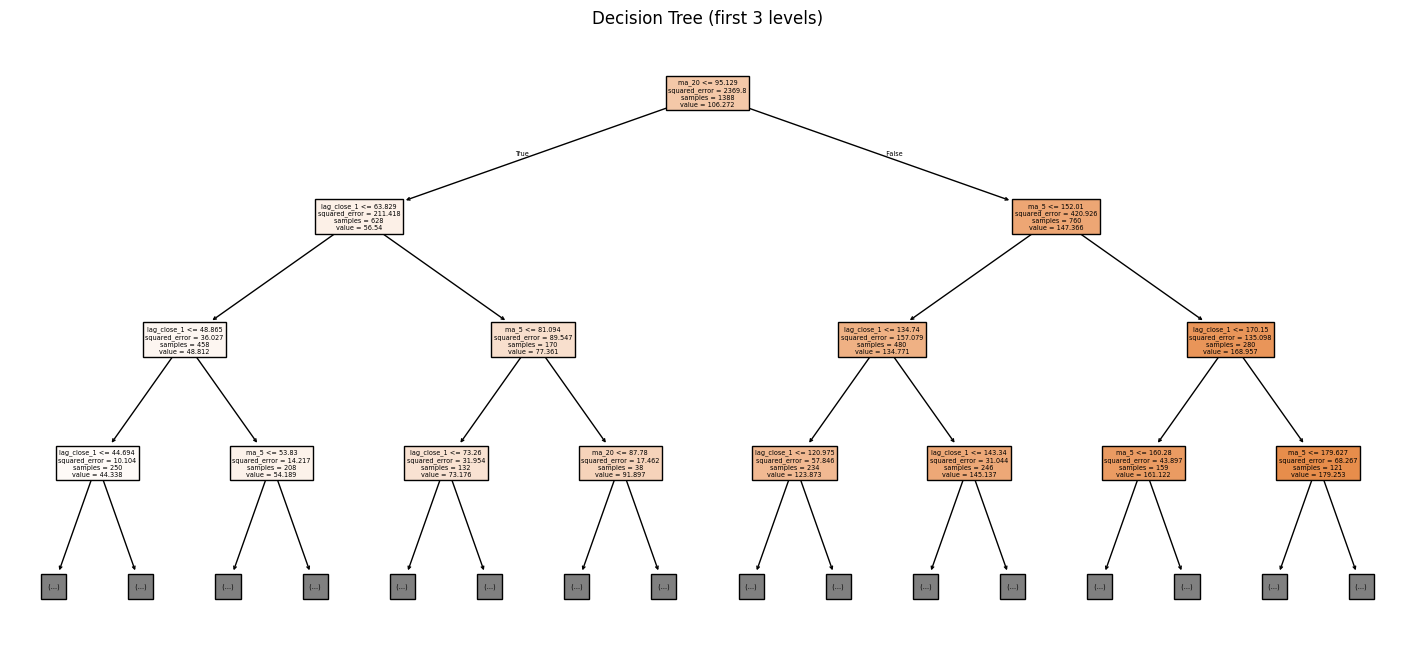

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Feature importance
fi = pd.Series(best_dt.feature_importances_, index=X_train.columns).sort_values(ascending=False)  # [web:6]
print(fi)

# Optional: plot the tree (only if it's not huge)
plt.figure(figsize=(18, 8))
plot_tree(best_dt, feature_names=X_train.columns, filled=True, max_depth=3)  # [web:413]
plt.title("Decision Tree (first 3 levels)")
plt.show()


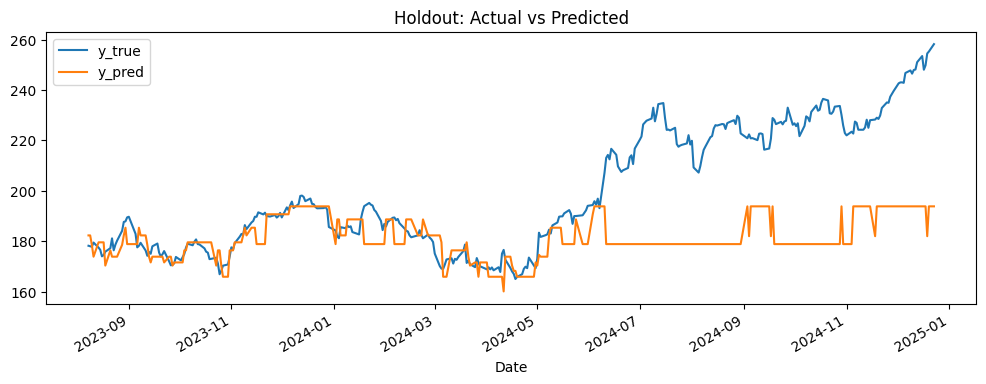

In [85]:

pred_df = pd.DataFrame({"y_true": y_test, "y_pred": y_pred}, index=y_test.index)
pred_df[["y_true", "y_pred"]].plot(figsize=(12,4), title="Holdout: Actual vs Predicted")
plt.show()


In [86]:
import joblib
joblib.dump(best_dt, "decision_tree_model.joblib")
joblib.dump(features, "feature_list.joblib")


['feature_list.joblib']

In [87]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1) Predict on holdout
y_pred = best_dt.predict(X_test)  # [web:6]

# 2) Tree metrics
mae_tree = mean_absolute_error(y_test, y_pred)                 # [web:119]
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred))        # [web:21]

# 3) Naive baseline: predict tomorrow = today (lag_close_1)
y_pred_naive = X_test["lag_close_1"].values
mae_naive = mean_absolute_error(y_test, y_pred_naive)          # [web:119]
rmse_naive = np.sqrt(mean_squared_error(y_test, y_pred_naive)) # [web:21]

print("DecisionTree MAE:", mae_tree, "RMSE:", rmse_tree)
print("Naive      MAE:", mae_naive, "RMSE:", rmse_naive)
print("MAE improvement (naive - tree):", mae_naive - mae_tree)
print("RMSE improvement (naive - tree):", rmse_naive - rmse_tree)


DecisionTree MAE: 19.72341728905141 RMSE: 28.240585169960827
Naive      MAE: 2.946379036738955 RMSE: 3.953055178134284
MAE improvement (naive - tree): -16.777038252312458
RMSE improvement (naive - tree): -24.287529991826542


In [88]:
import joblib
import pandas as pd

# Optional: load from disk if you're in a fresh session
# best_dt = joblib.load("decision_tree_model.joblib")  # [web:425]
# features = joblib.load("feature_list.joblib")        # [web:425]

latest_X = X.iloc[[-1]][features]   # keep as 2D DataFrame with correct columns
next_close_pred = best_dt.predict(latest_X)[0]  # [web:6]

print("Predicted next-day Close:", next_close_pred)
print("Based on last available date:", X.index[-1])


Predicted next-day Close: 193.8300007411412
Based on last available date: 2024-12-23 00:00:00


In [89]:
assert list(X.columns) == list(features)
assert latest_X.isna().sum().sum() == 0
